In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/1d')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [4]:
import sys
sys.path.append(ROOT)

In [5]:
import torch
import pickle
from utils.tools import load_pickle

from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.initializations import *
from utils.plot.abc_parameterizations.one_d_functions import *
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected import ntk, ip, muP, ipllr
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP

## Set variables

In [6]:
SEED = 42
N_SAMPLES = 100
N_TRAIN = 10
BASE_LR = 0.1

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)
base_config = ModelConfig(config_dict)

# modify config for this notebook
base_config.architecture['input_size'] = 1
base_config.architecture['output_size'] = 1
base_config.architecture['bias'] = False
base_config.activation.name = 'relu'
base_config.loss.name = 'mse'
base_config.optimizer.params['lr'] = BASE_LR

In [7]:
xs, ys = generate_1d_data(n_samples=10)

## Define models

In [8]:
WIDTHS = [1024]
N_WARMUP_STEPS = 1  # 4
L = 4
N_TRIALS = 5  # 5
N_EPOCHS = 1200 # 6000

In [9]:
name_to_model_dict = {
    'StandardIP': StandardFCIP,
    'NTK': ntk.FCNTK,
    'muP': muP.FCmuP,
    'IPLLR': ipllr.FcIPLLR
}

In [10]:
models_dict = dict()
for name, model in name_to_model_dict.items():
    models_dict[name] = dict()
    for width in WIDTHS:  # define models with different widths
        # first modify the base common config
        config = deepcopy(base_config)
        config.name = name
        config.architecture['width'] = width
        config.architecture['n_layers'] = L + 1
        
        if name == 'IPLLR':
            scheduler_config = {'name': 'warmup_switch', 
                                'params': {'n_warmup_steps': N_WARMUP_STEPS}}
            config.scheduler = BaseConfig(scheduler_config)
        if 'IP' in name:
            config.optimizer.params['lr'] = 0.5
        if name == 'muP':
            config.optimizer.params['lr'] = 0.1
        
        # define N_TRIALS random initializations of the same model
        models_dict[name][width] = [name_to_model_dict[name](config) for _ in range(N_TRIALS)]

### Set U and v to be the same for all models

In [11]:
for name in models_dict.keys():
    if name != 'NTK':
        for width in WIDTHS:
            for i in range(N_TRIALS):
                ntk = models_dict['NTK'][width][i]
                model = models_dict[name][width][i]
                with torch.no_grad():
                    model.copy_initial_params_from_model(ntk, check_model=True)
                    model.initialize_params()

In [12]:
init_dict = dict()
for name in models_dict.keys():
    init_dict[name] = dict()
    for width in WIDTHS:
        init_dict[name][width] = [deepcopy(model) for model in models_dict[name][width]]

In [13]:
models_dict_copy = deepcopy(models_dict)

In [14]:
batch_xs = torch.unsqueeze(xs, 1)
batch_ys = torch.unsqueeze(ys, 1)
#for name in models_dict.keys():
#    for width in WIDTHS:
#        for model in models_dict[name][width]:
#            fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

#for name in ['IPLLR']:
for name in ['muP']:
    for width in WIDTHS:
        for model in models_dict[name][width]:
            fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


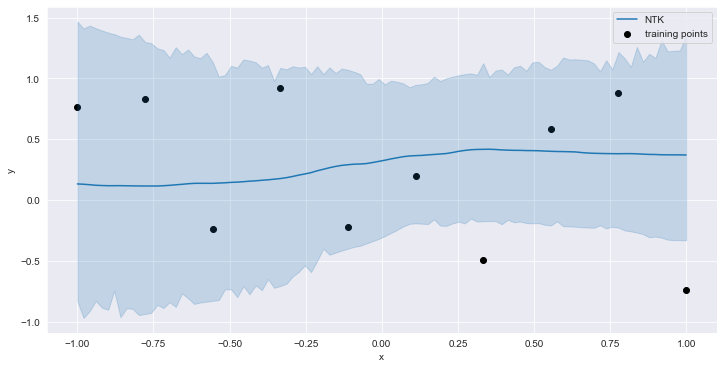

In [15]:
# INIT 
name = 'NTK'
plt.figure(figsize=(12, 6))
plot_model(init_dict[name][1024], xs, ys, label=name, scatter=True)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


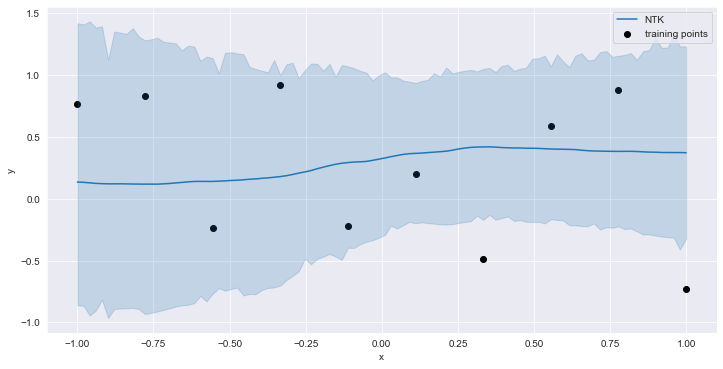

In [16]:
name = 'NTK'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


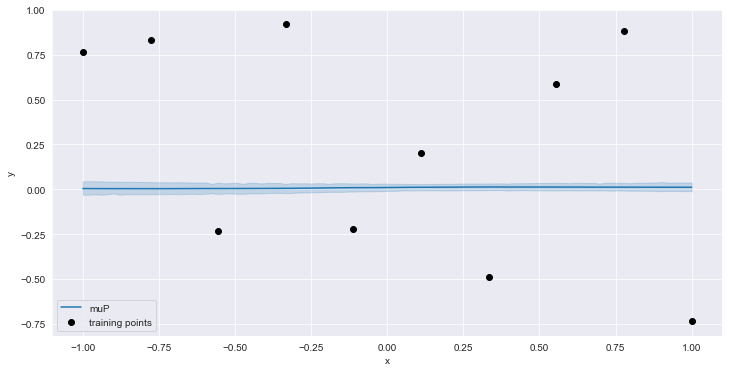

In [17]:
# INIT 
name = 'muP'
plt.figure(figsize=(12, 6))
plot_model(init_dict[name][1024], xs, ys, label=name, scatter=True)

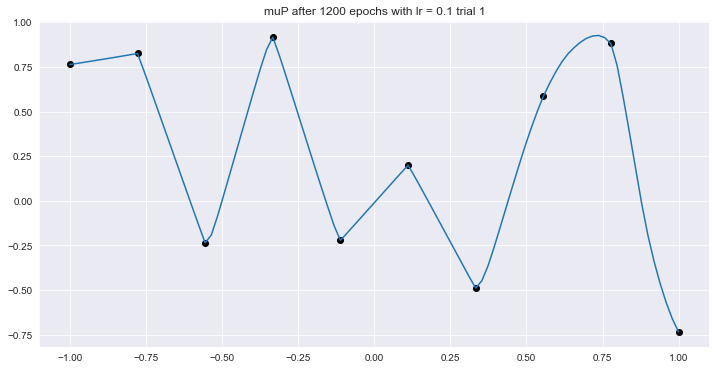

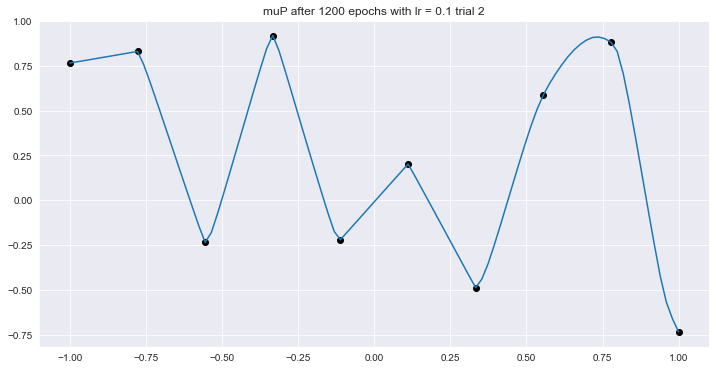

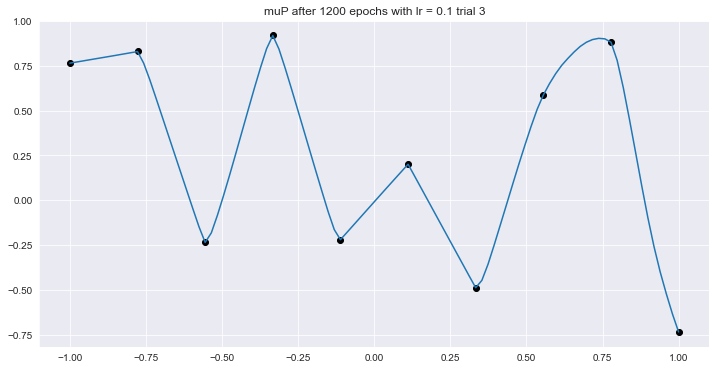

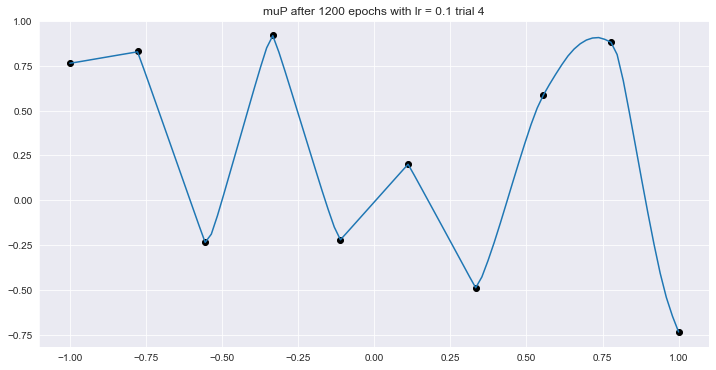

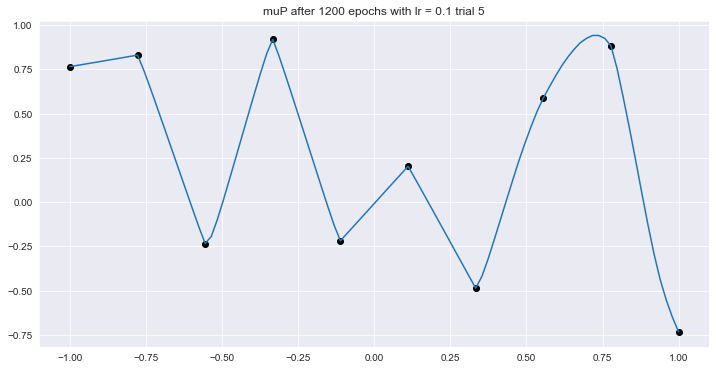

In [18]:
name = 'muP'
for k in range(len(models_dict[name][1024])):
    model = models_dict[name][1024][k]
    plt.figure(figsize=(12, 6))
    plot_model(model, xs, ys, label=name, scatter=True)
    plt.title('muP after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))
    # plt.ylim(-0.0001, 0.0001)
    plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


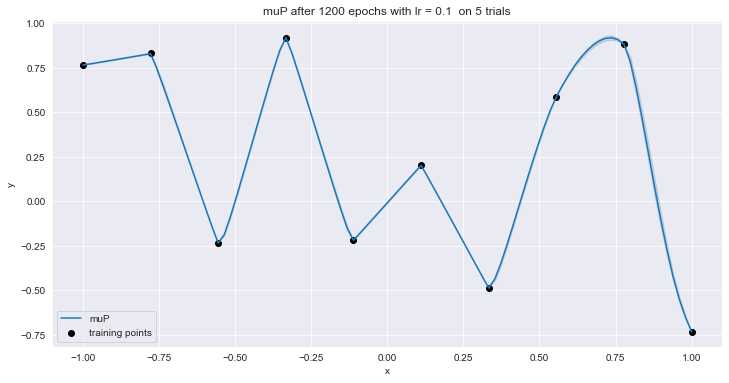

In [19]:
name = 'muP'
base_lr = models_dict[name][1024][0].base_lr
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True)
# plt.ylim(-0.0001, 0.0001)
plt.title('muP after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))
plt.show()

In [20]:
name='muP'

In [21]:
print(models_dict[name][1024][2].output_layer.weight.detach().numpy()[0])

[-0.03092727 -0.06125126  0.03939531 ...  0.10740279 -0.02116036
 -0.09324417]


In [22]:
model = models_dict[name][1024][2]
for l, layer in enumerate(model.intermediate_layers):
    if l == model.n_layers - 3:  # L-th layer
        print(layer.weight.detach().numpy())

[[ 0.01559984  0.01424613  0.0062266  ... -0.07335956  0.04923712
   0.05160564]
 [ 0.00382444 -0.00518243  0.05867507 ...  0.08687229 -0.0404416
  -0.07326638]
 [-0.09672663 -0.07311741 -0.06626624 ...  0.02928622 -0.02660435
  -0.03677069]
 ...
 [-0.04523156 -0.03398616 -0.04834904 ...  0.04047196 -0.05731403
  -0.00152936]
 [ 0.02322572 -0.03496695 -0.0100135  ...  0.01076862 -0.00361618
  -0.01201347]
 [ 0.02413454 -0.03365975  0.00923829 ...  0.02645542 -0.05300125
  -0.10434562]]


In [23]:
layer.weight.min()

tensor(-0.2221, grad_fn=<MinBackward1>)

In [24]:
layer.weight.max()

tensor(0.2127, grad_fn=<MaxBackward1>)

In [25]:
layer.weight.mean()

tensor(-7.9480e-05, grad_fn=<MeanBackward0>)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


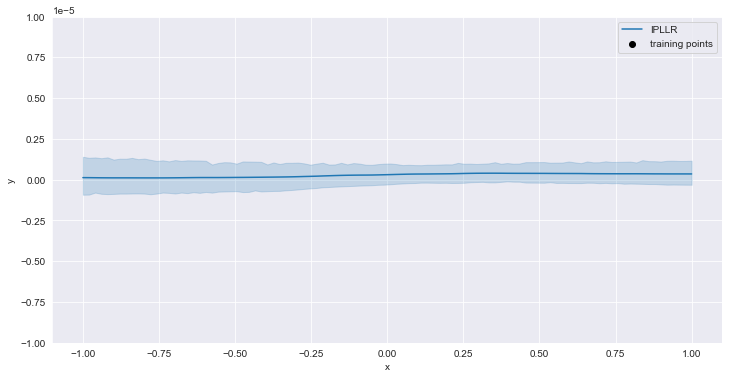

In [26]:
# INIT 
name = 'IPLLR'
plt.figure(figsize=(12, 6))
plot_model(init_dict[name][1024], xs, ys, label=name, scatter=True)
plt.ylim(-0.00001, 0.00001)
plt.show()

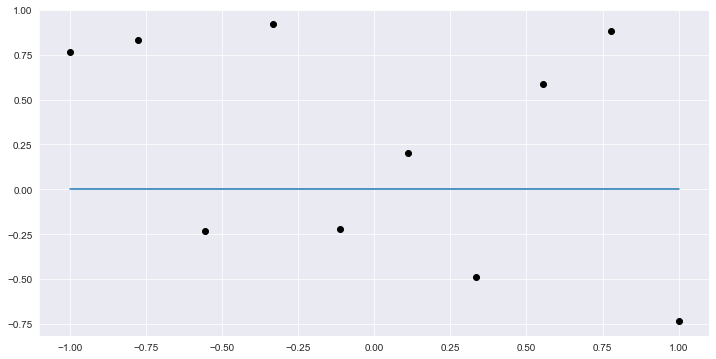

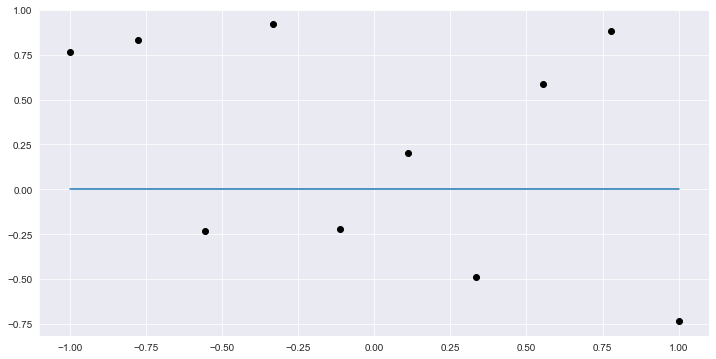

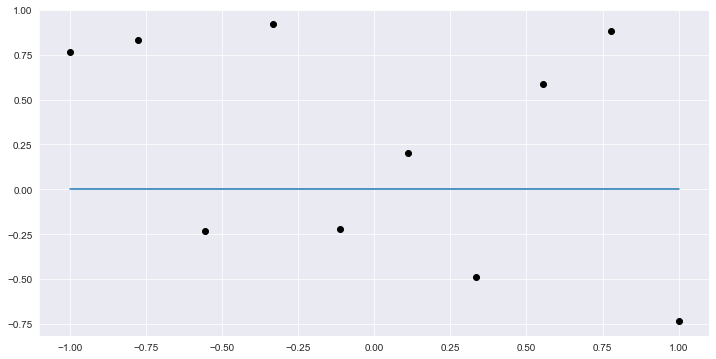

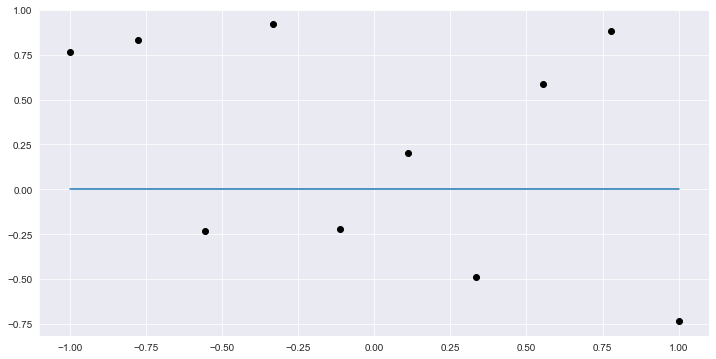

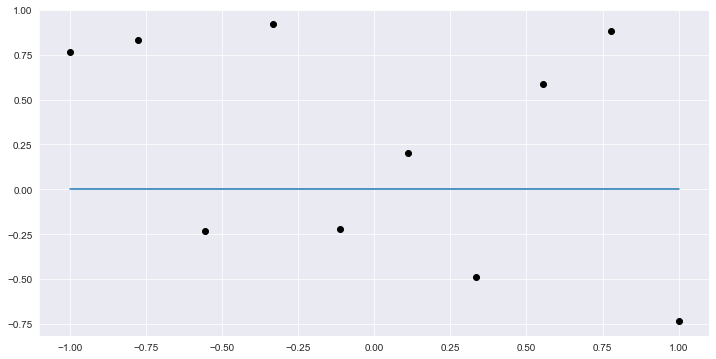

In [27]:
name = 'IPLLR'
for k in range(len(models_dict[name][1024])):
    model = models_dict[name][1024][k]
    plt.figure(figsize=(12, 6))
    plot_model(model, xs, ys, label=name, scatter=True)
    #plt.title('IPLLR after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    #plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))

    # plt.ylim(-0.0001, 0.0001)
    plt.show()

In [28]:
name = 'muP'

In [29]:
model = init_dict[name][1024][2]
print(model.output_layer.weight.detach().numpy()[0])

[-0.03141536 -0.01722218  0.01938265 ...  0.02834406  0.00065729
 -0.01675453]


In [30]:
for l, layer in enumerate(model.intermediate_layers):
    if l == model.n_layers - 3:  # L-th layer
        print(layer.weight.detach().numpy())

[[ 1.5647655e-02  1.5208764e-02  6.7893304e-03 ... -7.3322937e-02
   4.9237117e-02  5.1859893e-02]
 [ 2.4250438e-03 -7.0281015e-03  5.9026755e-02 ...  8.3859473e-02
  -4.2747140e-02 -7.4906468e-02]
 [-9.5561072e-02 -7.1692593e-02 -6.5078154e-02 ...  3.0724436e-02
  -2.5359912e-02 -3.5532687e-02]
 ...
 [-4.1391600e-02 -3.2028366e-02 -4.7558170e-02 ...  4.5891527e-02
  -5.3173922e-02  7.2466784e-05]
 [ 2.2847509e-02 -3.4576852e-02 -9.4511155e-03 ...  1.0109106e-02
  -4.1073053e-03 -1.1762757e-02]
 [ 2.3068115e-02 -3.5547804e-02  1.0207133e-02 ...  2.6382994e-02
  -5.5251759e-02 -1.0447803e-01]]


In [31]:
print(models_dict[name][1024][2].output_layer.weight.detach().numpy()[0])

[-0.03092727 -0.06125126  0.03939531 ...  0.10740279 -0.02116036
 -0.09324417]


In [32]:
layer.weight.min()

tensor(-0.2221, grad_fn=<MinBackward1>)

In [33]:
layer.weight.max()

tensor(0.2127, grad_fn=<MaxBackward1>)

In [34]:
model = models_dict[name][1024][2]
for l, layer in enumerate(model.intermediate_layers):
    if l == model.n_layers - 3:  # L-th layer
        print(layer.weight.detach().numpy())

[[ 0.01559984  0.01424613  0.0062266  ... -0.07335956  0.04923712
   0.05160564]
 [ 0.00382444 -0.00518243  0.05867507 ...  0.08687229 -0.0404416
  -0.07326638]
 [-0.09672663 -0.07311741 -0.06626624 ...  0.02928622 -0.02660435
  -0.03677069]
 ...
 [-0.04523156 -0.03398616 -0.04834904 ...  0.04047196 -0.05731403
  -0.00152936]
 [ 0.02322572 -0.03496695 -0.0100135  ...  0.01076862 -0.00361618
  -0.01201347]
 [ 0.02413454 -0.03365975  0.00923829 ...  0.02645542 -0.05300125
  -0.10434562]]


In [35]:
layer.weight.min()

tensor(-0.2221, grad_fn=<MinBackward1>)

In [36]:
layer.weight.max()

tensor(0.2127, grad_fn=<MaxBackward1>)

In [37]:
layer.weight.mean()

tensor(-7.9480e-05, grad_fn=<MeanBackward0>)

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


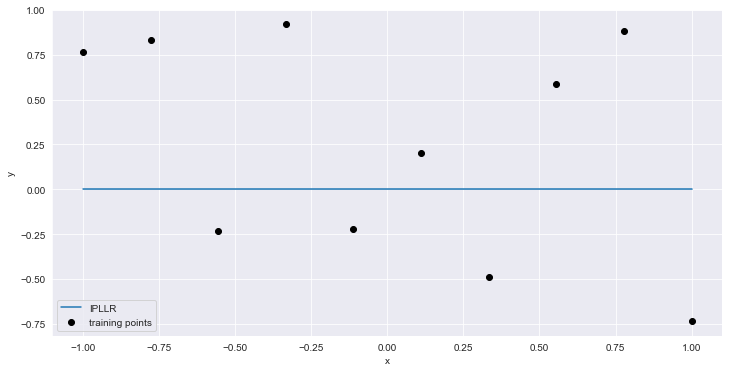

In [38]:
name = 'IPLLR'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True)
# plt.ylim(-0.0001, 0.0001)
#plt.title('IPLLR after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


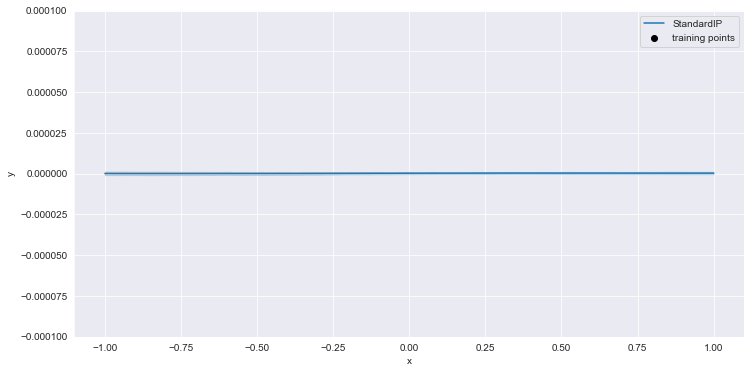

In [39]:
# INIT 
name = 'StandardIP'
plt.figure(figsize=(12, 6))
plot_model(init_dict[name][1024], xs, ys, label=name, scatter=True)
plt.ylim(-0.0001, 0.0001)
plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


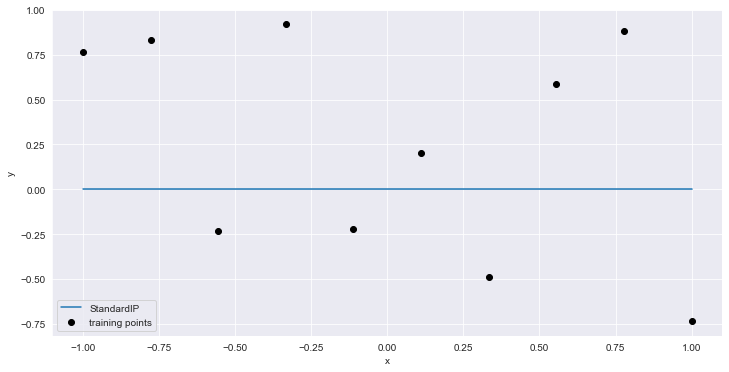

In [40]:
name = 'StandardIP'
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True)
#plt.ylim(-0.0001, 0.0001)
plt.show()

### Training

In [41]:
# models = deepcopy(init_dict)

In [42]:
#name = 'NTK'
#plt.figure(figsize=(12, 6))
#plot_training(models[name][1024], xs, ys, label=name)
#plt.show()

In [43]:
#x = np.linspace(0, 6*np.pi, 100)
#y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
#plt.ion()

#fig = plt.figure()
#ax = fig.add_subplot(111)
#line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma

#for phase in np.linspace(0, 10*np.pi, 500):
#    line1.set_ydata(np.sin(x + phase))
#    fig.canvas.draw()
#    fig.canvas.flush_events()